# ARID1A acetylproteomics cis comparison

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Endometrial Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [2]:
en_object = cptac.Endometrial()
desired_cutoff = .2

endometrial_freq_mut = al.get_frequently_mutated(en_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(endometrial_freq_mut), '\n')
endometrial_freq_mut.loc[endometrial_freq_mut['Gene'] == 'ARID1A']

                                    

Number of Frequently Mutated Genes: 10 



,Gene,Unique_Samples_Mut,Missence_Mut,Truncation_Mut
0,ARID1A,0.452632,0.136842,0.4


## Step 3: Select ARID1A, a frequently mutated gene

In [3]:
gene = 'ARID1A'

## Step 4: Select acetylproteomics

In [4]:
omics = en_object.get_acetylproteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. The first three steps are found in the format_phospho_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

In [5]:
# Create dataframe in order to do comparisons with wrap_ttest
omics_and_mut = en_object.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'acetylproteomics', omics_genes = gene)

# Create the binary column needed to do the comparison (later on)
omics_and_mut['binary_mutations'] = omics_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - format for loop (only phospho)
tumors = omics_and_mut.loc[omics_and_mut['Sample_Status'] == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status", "binary_mutations"]
only_acetyl = tumors.drop(columns_to_drop, axis = 1)

In [13]:
print("Doing t-test comparison for mutation status\n")
pval_df = pd.DataFrame()
for col_label, content in only_acetyl.items():
    formatted_acetyl_df = f.format_phospho_cis_comparison(en_object, 'acetylproteomics', gene, col_label)
    
    # check correctly formatted
    check_binary = len(formatted_acetyl_df['binary_mutations'].unique()) == 2
    check_num_data = len(formatted_acetyl_df.index) > 9 # (95 * .1) = 9.5
    if check_num_data & check_binary:
        omics_col_list = [col_label] #list of specific column label (for ttest)
        significant_pval_results = al.wrap_ttest(formatted_acetyl_df, 'binary_mutations', omics_col_list)
        pval_df = pval_df.append(significant_pval_results, ignore_index = True)

pval_df # print to see significant tests

Doing t-test comparison for mutation status

No significant comparisons.
No significant comparisons.
No significant comparisons.


,Comparison,P_Value
0,ARID1A-K1953_acetylproteomics,0.006449
1,ARID1A-K980_acetylproteomics,0.000319


In [14]:
# create data frame for boxplot with all sig sites
acetyl_list = list(pval_df['Comparison'])
all_data = pd.DataFrame()
for acetyl_name in acetyl_list:
    real = omics_and_mut[[acetyl_name, "binary_mutations"]].dropna(axis = 0) #drop rows with missing measurements
    concise_acetyl_name = acetyl_name.replace('_acetylproteomics', '') #shorten col names
    real = real.assign(specific_acetyl = concise_acetyl_name)
    real = real.rename(columns={ real.columns[0]: "acetylproteomics" })
    all_data = pd.concat([real, all_data], axis = 0)
#all_data.loc[all_data['specific_phospho'] == 'ARID1A-S1182']
all_data.head()

,acetylproteomics,binary_mutations,specific_acetyl
Sample_ID,,,
S003,-0.1340,Wildtype,ARID1A-K980
S006,0.2510,Wildtype,ARID1A-K980
S008,-0.0523,Mutated,ARID1A-K980
S010,0.2690,Wildtype,ARID1A-K980
S012,-0.4595,Mutated,ARID1A-K980


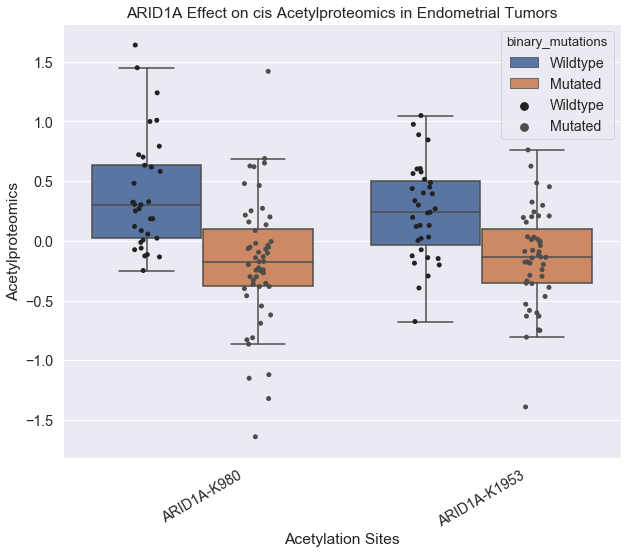

In [16]:
# Step 5 - Create boxplot to compare wildtype and mutated effect on omics data
plt.rcParams['figure.figsize']=(10,8) #size of plot
sns.set(font_scale = 1.3)
en_cis_boxplot = sns.boxplot(data = all_data, x = 'specific_acetyl', y = 'acetylproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False)  
en_cis_boxplot.set_title(gene + " Effect on cis Acetylproteomics in Endometrial Tumors")
en_cis_boxplot = sns.stripplot(data= all_data, x = 'specific_acetyl', y = 'acetylproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
en_cis_boxplot.set(xlabel = 'Acetylation Sites', ylabel = "Acetylproteomics")
en_cis_boxplot.set_xticklabels(en_cis_boxplot.get_xticklabels(), rotation = 30)
plt.show()
plt.clf()
plt.close()

There is a decrease in ___ in the mutated samples compared to the wildtype.

Mutation type comparison

In [9]:
# check all or just sig from last test?
mutation_type_pval = pd.DataFrame()
for name in acetyl_list:
    formated_phospho = f.get_missence_truncation_phospho(en_object, 'acetylproteomics', gene, name)
    check_num_sample = len(formated_phospho) > 9
    if check_num_sample:
        omics_col_list = [name] #list of specific column label (for ttest)
        significant_pval_results = al.wrap_ttest(formated_phospho, 'binary_mutations', omics_col_list)
        mutation_type_pval = mutation_type_pval.append(significant_pval_results, ignore_index = True)
mutation_type_pval

No significant comparisons.
No significant comparisons.


""


No significant comparisons for mutation type.

# Repeat with the Colon dataset

Go through the same process, this time using the Colon dataset. We will only print five genes from the frequently mutated data frame for simplicity.

In [10]:
colon_object = cptac.Colon()
desired_cutoff = .2

colon_freq_mut = al.get_frequently_mutated(colon_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(colon_freq_mut), '\n')
colon_freq_mut.loc[colon_freq_mut['Gene'] == 'ARID1A']

                                    

Number of Frequently Mutated Genes: 39 



,Gene,Unique_Samples_Mut,Missence_Mut,Truncation_Mut
3,ARID1A,0.237113,0.072165,0.185567


In [11]:
gene = 'ARID1A'

In [12]:
# this cell gives an error because there is not a acetylproteomic dataframe for the colon dataset
omics_mutations = colon_object.join_omics_to_mutations(
        mutations_genes = gene, omics_df_name = 'acetylproteomics', omics_genes = gene)

DataframeNotIncludedError: acetylproteomics dataframe not included in this dataset.

Acetylproteomics dataframe is not included in the colon dataset. Not possible to do the cis comparison.

# Visualize Pancancer effects

In [ ]:
# Step 5 - Create boxplot to compare wildtype and mutated effect on omics data
plt.rcParams['figure.figsize']=(10,8) #size of plot
sns.set(font_scale = 1.5)
en_cis_boxplot = sns.boxplot(data = all_data, x = 'specific_acetyl', y = 'acetylproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False)  
en_cis_boxplot.set_title(gene + " Effect on cis Acetylproteomics in Endometrial Tumors")
en_cis_boxplot = sns.stripplot(data= all_data, x = 'specific_acetyl', y = 'acetylproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
en_cis_boxplot.set(xlabel = 'Acetylation Sites', ylabel = "Acetylproteomics")
en_cis_boxplot.set_xticklabels(en_cis_boxplot.get_xticklabels(), rotation = 30)
plt.show()
plt.clf()
plt.close()

# Analysis of Results

The endometrial dataset showed a decrease in acetylproteomics accross the two signifcant sites. The colon dataset contained no data for ARID1A acetylproteomics.